<a href="https://colab.research.google.com/github/piusAI/DeepLearning_Basic/blob/main/Chap05_05_Learn_Implement_from_Back_Propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BackPropagation

### Prepration TwoLayerNet

#### def Function

In [2]:
import numpy as np
import keras.datasets.mnist as mnist

mnist.load_data()

def sigmoid(x):
  return 1 / 1+ np.exp(-x)

def softmax(a):
  if a.ndim==2:
    a = a - np.max(a, axis=1, keepdims=1)
    y = np.exp(a) / np.sum(np.exp(a), axis=1, keepdims=1)
  else:
    a = a - np.max(a)
    y = np.exp(a) / np.sum(np.exp(a))
  return y

def CEE(y, t):
  if y.ndim==1:
    y.reshape = (y.shape[0], -1)
    t.reshape = (t.shape[0], -1)
  batch_size = y.shape[0]
  loss = np.log(np.sum( y[np.arange(batch_size),t] )) /batch_size
  return loss

def _nobatch_numerical_gradient(f,x):
  h = 1e-4
  grad = np.zeros_like(x)
  for idx in range(x.size):
    tmp_val = idx
    x[idx] = float(tmp_val)+h
    fxh1 = f(x)

    x[idx] = tmp_val -h
    fxh2 = f(x)
    grad[idx] = (fxh1- fxh2) / 2* h
    x[idx] = tmp_val
  return grad

def numerical_gradient(f,X):
  if X.ndim==1:
    return _nobatch_numerical_gradient(f,X)
  else:
    grad = np.zeros_like(X)
    for idx in enumerate(X):
      grad[idx] = _nobatch_numerical_gradient(f,idx)
    return grad

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Def Code - Relu, Affine, SoftmaxWithLoss - 따라침

In [3]:
import numpy as np

class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x<=0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask]=0
    dx = dout

    return dx

class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b

    self.x = None
    self.original_x_shape = None

    self.dW = None
    self.db = None

  def forward(self, x):
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)

    self.x = x
    out = np.dot(self.x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.original_x_shape)
    return dx

class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = CEE(self.y, self.t)

    return self.loss

  def backward(self, dout = 1):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size

    else :
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -=1
      dx = dx/ batch_size
    return dx

위 코드 직접 구현 추후 해보기

### Implement TwoLayer Net

In [8]:
from collections import OrderedDict

class TwolayerNet():
  def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
    self.params={}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

    self.lastlayer = SoftmaxWithLoss() #따로 넣음

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forwad(x)
    return x
    # Call Score!
    # predict할때는, Train이 아니기 때문에, Softmax까지 갈 필요 없음
    ## => softmax는 단조 증가함수이기에 그저 커지기만함!

  def loss(self, x,t):
    y = self.x.predict(x)
    return self.lastlayer.forward(y,t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1 : t= np.argmax(t, axis=1)

    accuracy = np.sum(y==t) / float(x.shape[0])
    return accuracy

  def numerical_gradient(self, x, t):
    loss_w = lambda t: self.loss(x,t)
    grads={}
    grads['W1'] = numerical_gradient(loss_w, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_w, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_w, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_w, self.params['b2'])

    return grads

  def gradient(self, x, t):
    self.loss(x,t)

    dout = 1
    dout = self.lastlayer.backward(dout)

    layers= list(self.layers.values()) # set the List Values of Layers [Affine1, Relu1, Affine2]
    layers.reverse() # Reverse Layers [Affine2, Relu1, Affine1]
    for layer in layers:
      dout = layer.backward(dout)

    grads={}
    grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
    #dW, db는 각각 Weight gradient, bias gradient!

    return grads

✅ 정리 요약

-

1.   역전파시, 순서가 중요하기떄문에 OrderedDiction으로!


➡ Affine1 => Relu1 => Affine2 이 순서가 중요!

2.   predict는 Softmax이전까지의 Forward(순전파)

3.   forward는 Affine.forward, Relu.forward의 순전파 Module

|||
|--|--|
| 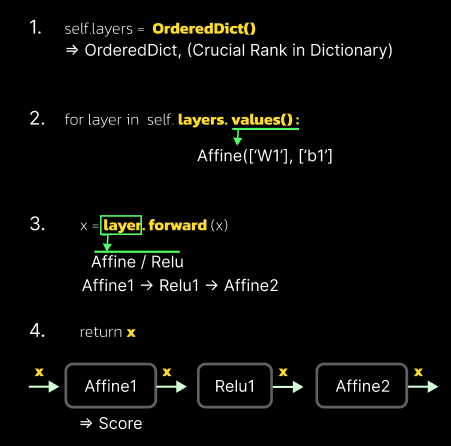| 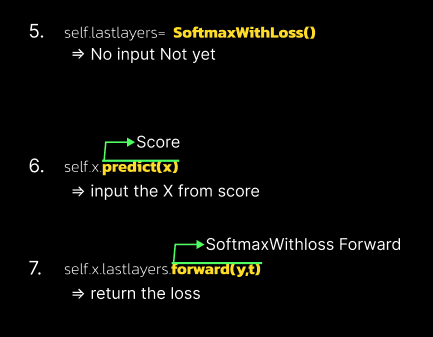|
|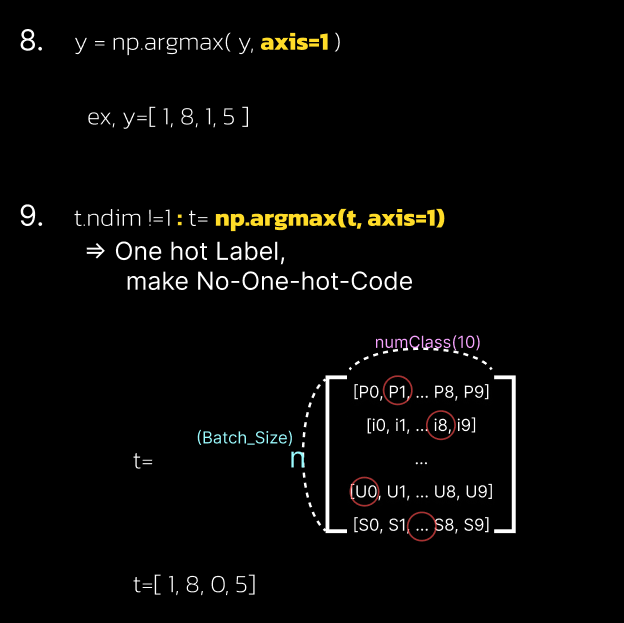|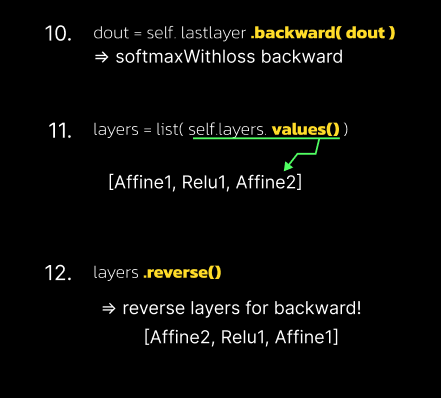|

In [4]:
tl = TwolayerNet(input_size = 784, hidden_size = 50, output_size = 10)

print(tl.layers.values())
print(tl.layers.keys())

odict_values([<__main__.Affine object at 0x7c937c954fd0>, <__main__.Relu object at 0x7c936fe55810>, <__main__.Affine object at 0x7c9407730250>])
odict_keys(['Affine1', 'Relu1', 'Affine2'])


=> Key, Value를 확인할 수 있다

#### OrderedDictionary?

In [5]:
from collections import OrderedDict

a = {'Pius' : "Ai", "JGAi" : "Soccer", "SaaS" : "Service"}
b = {"JGAi" : "Soccer", "SaaS" : "Service",'Pius' : "Ai" }

c=OrderedDict(a)
d=OrderedDict(b)

print(a==b)
print(c==d)

l_av=list(a.values())
l_ck=list(c.keys())

print(l_av)
print(l_ck)

print(l_ck.reverse())

True
False
['Ai', 'Soccer', 'Service']
['Pius', 'JGAi', 'SaaS']
None


- Dictionary는 순서에 구애 받지 않는 Key-Value.
- OrderDictionary는 순서에 구애 받는다.

In [6]:
G = {1:"S",2:"i",3:"u",4:"u0"}
keys=list(OrderedDict(G).keys())
keys.reverse() # 바로 실행되어서 return None, 바로 print 불가

values=list(OrderedDict(G).values())
values.reverse()
print(values)
print(keys)

['u0', 'u', 'i', 'S']
[4, 3, 2, 1]


In [7]:
X=np.random.randn(4,4)
X=X.reshape(1,-1)
print(X)

Y = list(X.flatten())
Y.reverse()
print(Y)

[[ 1.576067    0.43247501 -0.75983999  0.27056541 -0.7475473  -0.26534756
  -0.8437075   2.00347578  0.06418986 -2.31482928 -1.39511087  1.3890572
  -0.50880335 -1.39898744 -1.37577703 -0.60905863]]
[np.float64(-0.6090586271651723), np.float64(-1.3757770295543883), np.float64(-1.398987435058911), np.float64(-0.508803345910038), np.float64(1.3890571989462936), np.float64(-1.3951108671428054), np.float64(-2.3148292769278904), np.float64(0.06418985947408862), np.float64(2.003475781163991), np.float64(-0.8437075001338964), np.float64(-0.265347561975454), np.float64(-0.7475472958771879), np.float64(0.27056541330361383), np.float64(-0.7598399925615957), np.float64(0.4324750107194574), np.float64(1.5760669993585656)]


#### Implement Propagation ConCeptual Flow

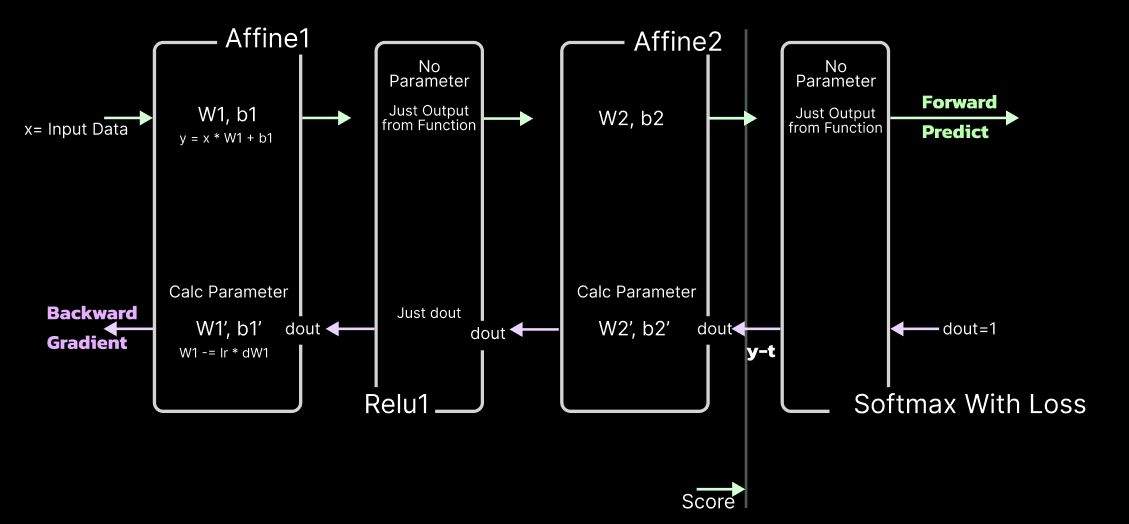